## Running AEM forward model on the output random forest

In [1]:
%load_ext autoreload
%autoreload 2
# %aimport funcs

from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
import numpy as np
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
sns.set(color_codes=True)
from scipy.stats import hmean
from scipy import interpolate
from funcs import *

In [2]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

### Import data exported from WellProcessing.ipynb

In [3]:
importSoquel = True
if importSoquel:
    df =  pd.read_pickle(lasdir.joinpath('allMWs_SC'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_SC_ind'))
else:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))

df2 =update_df2(df)
MPWSPnames = df2.loc[~df2.FRES.isna(),'Well'].unique()
MWnames = df.index.levels[0].values


aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
aqnum = -1*np.ones(len(df),dtype='Int32')
wellids = MWnames

for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)

for i,aq in enumerate(aq_names):
    aqnum[df.Aquifer == aq_names[i]] = i
df=df.assign(aqnum=aqnum)


# df.loc['MW-4D'].loc[328:,'RILD']=np.nan
df2 = update_df2(df)
welldict = {}
for i,nam in enumerate(wellids):
    welldict[nam]=i

df_testing = pd.read_pickle(auxdir.joinpath('df_testing_xval')) 
y_predict = load_obj(auxdir,'y_predict_xval')
df_testing = df_testing.assign(err_sq = (df_testing.preds - df_testing.logrild)**2 )
estimators = load_obj(auxdir,'estimators_xval')
samps = load_obj(auxdir,'samps_xval')

In [4]:
import numpy as np
import scipy.interpolate as interpolate

def pred_ints(estimator, X, pred_mult=.10,percentile=95):
    preds = []
    for pred in estimator.estimators_:   
        preds.append(pred.predict(X))    
    preds = np.r_[preds]*pred_mult
    err_down = np.percentile(preds, (100 - percentile) / 2. ,axis=0)
    err_up = np.percentile(preds, 100 - (100 - percentile) / 2.,axis=0)
    return err_down, err_up, preds

# def inverse_transform_sampling(data, n_bins, n_samples,axis=None):
#     samps = np.zeros((data.shape[0],n_samples),dtype=np.float)
#     for i,row in enumerate(data):
#         hist, bin_edges = np.histogram(row, bins=n_bins, density=True)
#         cum_values = np.zeros(bin_edges.shape)
#         cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
#         inv_cdf = interpolate.interp1d(cum_values, bin_edges)
#         r = np.random.rand(n_samples)
#         samps[i] = inv_cdf(r)
        
    return samps
def logrho2cond(logrho):
    return 1/np.power(10,logrho)

def rho2cond(rho):
    return 1/rho

def cond2rho(cond):
    return 1/cond

def harm_avg(fine_data,grid,background=10):
    from scipy.stats import hmean
    coarse_data = background*np.ones(len(grid))
    for i,g in enumerate(grid[:-1]):
        avg_data = fine_data.loc[np.logical_and(fine_data.index<grid[i+1], fine_data.index > grid[i])]
        if len(avg_data>0):
            coarse_data[i] = hmean(avg_data)[0]
    return coarse_data

def harm_avg2(data_depth,data_value,grid,background=10):
    coarse_data = background*np.ones(len(grid))
    for i,g in enumerate(grid[:-1]):
#         avg_data = fine_data.loc[np.logical_and(fine_data.index<grid[i+1], fine_data.index > grid[i])]
        avg_data = data_value[np.where(np.logical_and(data_depth<grid[i+1], data_depth > grid[i]))]
        if len(avg_data>0):
            coarse_data[i] = hmean(avg_data)
    return coarse_data


In [5]:
from simpegEM1D import skytem_HM_2015
wave = skytem_HM_2015()
time = wave.time_gate_center[0::2]
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10., n_layer=40)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'stepoff',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time,
    base_frequency = 25.,
    use_lowpass_filter=False,
    high_cut_frequency=7e4        
)
#     sig_half = 1e-1
# sig_half= logrho2cond(df_testing.logrild).mean()
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

In [6]:
# np.save(auxdir.joinpath('hz.npy'),hz)

In [7]:
def forward_model(nam,sig_half=10,depth0=None,n_samples= 1000):
    from scipy import interpolate
#     estimator = estimators[welldict[nam]]
    predictors = ['FBS','aq_groupnum','X','Y','C']
    predicted ='logrild_bin'
    colorcolumn = 'aq_groupnum'

    testwell = nam
    print('testing on',nam)
    trainwells = [wellid for wellid in df_testing.Well.unique() if wellid!=testwell]
    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    df_test = df_testing.loc[df_testing.Well==testwell]

    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
    y_test = df_test.loc[:,'logrild']

#     estimator.fit(X_train,y_train)
# #     y_predict = estimator.predict(X_test)
#     y_train_predict = estimator.predict(X_train)
    
#     y_train = y_train/10
# #     y_predict = y_predict/10
#     y_train_predict = y_train_predict/10
#     err_down,err_up,preds = pred_ints(estimator, X_test, percentile=95)

# #     samps = inverse_transform_sampling(preds.T, 50, 200).T
#     bin_centers = estimator.classes_
#     dx=(bin_centers[1]-bin_centers[0])/2
#     bin_edges = np.r_[bin_centers - dx/2,bin_centers[-1]+dx/2]
#     samps = [inverse_transform_sampling(prob,n_bins=bin_edges,n_samples=n_samples) for prob in estimator.predict_proba(X_test)]
#     samps = np.asarray(samps).T


    df2_newdepth = df2.loc[df2.Well==nam,['DEPT','RILD']]
    df2_newdepth = df2_newdepth.dropna()
#     df2_newdepth = df2.loc[df2.Well==nam,['DEPT','RILD','logrild_pred_archie']]
#     df2_newdepth = df2_newdepth.drop(df2_newdepth.RILD.isna().index)

    if depth0 is None:
        depth0 = df2_newdepth.DEPT.min()
    df2_newdepth.loc[:,'DEPT'] = (df2_newdepth.DEPT - depth0)*.3048

    # y_true = df2.loc[df2.Well==nam,['DEPT','RILD']].set_index('DEPT')
    y_true = df2_newdepth.loc[:,['DEPT','RILD']]
    y_true.loc[y_true.RILD.isna()]=1/sig_half
    y_true = y_true.set_index('DEPT')

    y_true_values = y_true.RILD.values
    y_true_depth = y_true.index.values
    
    from simpegEM1D import skytem_HM_2015
    wave = skytem_HM_2015()
    time = wave.time_gate_center[0::2]
    hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10., n_layer=40)
    mesh1D = set_mesh_1d(hz)
    depth = -mesh1D.gridN[:-1]
    LocSigZ = -mesh1D.gridCC
    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+30.]),
        src_location = np.array([0., 0., 100.+30.]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'stepoff',
        src_type = 'CircularLoop',
        a = 13.,
        I = 1.,
        time = time,
        base_frequency = 25.,
        use_lowpass_filter=False,
        high_cut_frequency=7e4        
    )
#     sig_half = 1e-1
    # sig_half= logrho2cond(df_testing.logrild).mean()
    chi_half = 0.
    expmap = Maps.ExpMap(mesh1D)
    
    #Forward model the true data
    data_depth=y_true_depth
    data_value=y_true_values
    grid=-depth
    coarse_data = harm_avg2(data_depth,data_value,grid,1/sig_half)
    coarse_data[np.isnan(coarse_data)]=1/sig_half
    sig = rho2cond(coarse_data)
    m_true = np.log(sig)

    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    d_true = TDsurvey.dpred(m_true)
    y_pred_depth = (df_testing.loc[df_testing.Well==nam,'DEPT'].values-depth0)*.3048
    ind = np.r_[[np.where(d==y_true_depth)[0][0] for d in y_pred_depth]]
    y_arch_depth = (df_testing.loc[df_testing.Well==nam,'DEPT'].values-depth0)*.3048
    
    ###########Forward model Archie prediction
    archie = df_testing.loc[df_testing.Well==nam,'logrild_pred_ws'].values
    archie_depth = (df_testing.loc[df_testing.Well==nam,'DEPT'].values-depth0)*.3048
    ind = np.r_[[np.where(d==y_true_depth)[0][0] for d in archie_depth]]
    archie_values = y_true_values.copy()
    archie_values[ind] =  np.power(10,archie)

    coarse_data = harm_avg2(y_true_depth,archie_values,-depth,background=1/sig_half)
    coarse_data[np.isnan(coarse_data)]=1/sig_half
    sig = rho2cond(coarse_data)
    
    m_archie = np.log(sig)

    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    d_archie = TDsurvey.dpred(m_archie)
    #############################################
    
    ## Best RF Prediction
    y_predict_rf = df_testing.loc[df_testing.Well==nam,'logrild_pred_RF'].values
#     y_predict_rf = np.log10(1/np.power(10,df_testing.loc[df_testing.Well==nam,'logcild_mean_est'].values))
    
    
    
    rf_depth = (df_testing.loc[df_testing.Well==nam,'DEPT'].values-depth0)*.3048
    ind = np.r_[[np.where(d==y_true_depth)[0][0] for d in rf_depth]]
    rf_values = y_true_values.copy()
    rf_values[ind] =  np.power(10,y_predict_rf)

    coarse_data = harm_avg2(y_true_depth,rf_values,-depth,background=1/sig_half)
    coarse_data[np.isnan(coarse_data)]=1/sig_half
    sig = rho2cond(coarse_data)
    m_rf = np.log(sig)

    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    d_rf = TDsurvey.dpred(m_rf)
    #############################################

    
#     #Make sample from all of the trees and forward model
    m_preds = []
    d_preds = []
#     for i,pred in enumerate(preds):
#         pred = bin_wiggle(pred)
#         y_pred_values = y_true_values.copy()
#         y_pred_values[ind] =  np.power(10,pred)
#         coarse_data = harm_avg2(y_true_depth,y_pred_values,-depth,background=1/sig_half)
#         coarse_data[np.isnan(coarse_data)]=1/sig_half
#         sig = rho2cond(coarse_data)
#         m_preds.append(np.log(sig))

#         #Forward model
#         prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
#         if prob.ispaired:
#             prob.unpair()
#         if TDsurvey.ispaired:
#             TDsurvey.unpair()
#         prob.pair(TDsurvey)
#         prob.chi = np.zeros(TDsurvey.n_layer)
#         d_preds.append(TDsurvey.dpred(m_preds[i]))
        
    return m_true,d_true,m_archie,d_archie,m_rf,d_rf

In [8]:
allwells = df_testing.Well.unique()
md = {}
# 
for nam in allwells:
    (output) = forward_model(nam,depth0=None,sig_half=1/30,n_samples=1)
    md[nam] = output

testing on CX-B1
testing on CX-B2
testing on CX-B4
testing on MDW-1
testing on ML-1
testing on ML-2
testing on ML-3
testing on ML-4
testing on ML-6
testing on MW-1D
testing on MW-4D
testing on MW-5D
testing on MW-6D
testing on MW-7D
testing on MW-8D
testing on MW-9D
testing on PR-1


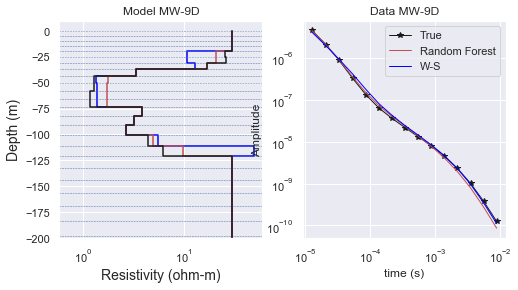

In [41]:
nam='MW-9D'
fig, axs = plt.subplots(1,2, figsize=(8, 4),squeeze=False)


i=0
# for i,nam in enumerate(allwells):
m_true,d_true,m_archie,d_archie,m_rf,d_rf = md[nam]
plt.sca(axs.flatten()[i])
# for pred in m_preds:
#     Utils1D.plotLayer(cond2rho(np.exp(pred)), mesh1D, showlayers=False,c='r',alpha=.05,linewidth=2)
Utils1D.plotLayer(cond2rho(np.exp(m_archie)), mesh1D, showlayers=False,linewidth=1.5,c='blue')
plt.xlim([.1,100])
Utils1D.plotLayer(cond2rho(np.exp(m_rf)), mesh1D, showlayers=False,linewidth=1.5,c='r')
Utils1D.plotLayer(cond2rho(np.exp(m_true)), mesh1D, showlayers=True,linewidth=1.5,c='k')#,xlim=[.5,75])
plt.ylim([-200,10])
plt.title('Model '+nam)
plt.xlabel('Resistivity (ohm-m)')
plt.ylabel('Depth (m)')


i=1
# axs[1].plot(TDsurvey.time, d_preds[0],c='r',alpha=1,label='Predicted',)
# axs[1].plot(TDsurvey.time, -np.r_[d_preds].T,c='r',alpha=.1)
plt.sca(axs.flatten()[i])
ax = plt.gca()
ax.plot(TDsurvey.time, -d_true,c='k',marker='*',linewidth=1,label='True')
ax.plot(TDsurvey.time, -d_rf,c='r',linewidth=1,label='Random Forest')
ax.plot(TDsurvey.time, -d_archie,c='blue',linewidth=1,label='W-S')

ax.set_xscale('log');
ax.set_yscale('log');
plt.xlabel('time (s)')
plt.ylabel('Amplitude')

plt.title('Data ' + nam)
plt.legend()
plt.savefig(figdir.joinpath('True_Archie_RF_'+nam+'.png'),dpi=300,bbox_inches='tight')

In [89]:
nam = 'MW-8D'
m_true,d_true,m_archie,d_archie,m_rf,d_rf = md[nam]
np.abs((d_true-d_archie)/d_true) - np.abs((d_true-d_rf)/d_true)

array([ 0.06681253,  0.07929182,  0.08507496,  0.08399507,  0.07561534,
        0.05729213,  0.03118418,  0.00110049, -0.02969585, -0.06209522,
       -0.10191908, -0.15275169, -0.1233014 , -0.05407687,  0.00503814])

array([-0.16517563, -0.07448462, -0.020897  , -0.03609529, -0.08918691,
       -0.16529598, -0.20890519, -0.21274163, -0.19438977, -0.18703621,
       -0.17898728, -0.1713824 , -0.16051046, -0.1451585 , -0.13056271])

In [67]:
def rmse(true,pred):
    return np.sqrt(np.mean((true-pred)**2))

nam = 'CX-B1'
m_true,d_true,m_archie,d_archie,m_rf,d_rf = md[nam]

print( np.sum(((m_true - m_archie)/m_true)**2))
print( np.sum(((m_true - m_rf)/m_true)**2))
print((m_true - m_archie )/m_true)

1727.0121610361832
734.0656804707373
[ -0.          -0.          -0.         -41.54597858   0.07507665
  -0.5892732   -0.          -0.45349124  -0.          -0.19854334
  -0.          -0.2711931   -0.12294665  -0.50715882  -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.        ]


In [9]:

#Norm pct error
from numpy.linalg import norm
err_m_arch = []
err_m_rf = []
err_d_arch = []
err_d_rf = []
for i,nam in enumerate(allwells):
    m_true,d_true,m_archie,d_archie,m_rf,d_rf = md[nam]
    ind = np.where(m_true - m_archie) #where the error>0

    m_true = np.log10(cond2rho(np.exp(m_true)))[ind]
    m_archie = np.log10(cond2rho(np.exp(m_archie)))[ind]
    m_rf = np.log10(cond2rho(np.exp(m_rf)))[ind]
    
    err_m_arch.append(100*np.round(norm(m_true-m_archie)/norm(m_true),3))
    err_m_rf.append(100*np.round(norm(m_true-m_rf)/norm(m_true),3))
    err_d_arch.append(100*np.round( norm((d_true-d_archie)/d_true)/norm(d_true/d_true),3))
    err_d_rf.append(100*np.round( norm((d_true-d_rf)/d_true)/norm(d_true/d_true),3))

#     err_m_arch.append(np.round(rmse(m_true,m_archie),3))
#     err_m_rf.append(np.round(rmse(m_true,m_rf),3))
#     err_d_arch.append(rmse(d_true,d_archie))
#     err_d_rf.append(rmse(d_true,d_rf))

        
err = np.vstack((err_m_arch,err_m_rf,err_d_arch,err_d_rf)).T
frame = pd.DataFrame(err,columns=['norm_err_m_archie','norm_err_m_RF','norm_err_d_archie','norm_err_d_RF'],index=allwells)
frame = frame.assign(PctChange_m_err = np.round(frame.norm_err_m_archie - frame.norm_err_m_RF,1))
frame = frame.assign(PctChange_d_err = np.round(frame.norm_err_d_archie - frame.norm_err_d_RF,1))
# frame.to_csv(auxdir.joinpath('True_Archie_RF_pcterrs.csv').as_posix())

frame

,norm_err_m_archie,norm_err_m_RF,norm_err_d_archie,norm_err_d_RF,PctChange_m_err,PctChange_d_err
CX-B1,30.9,35.4,2.7,3.7,-4.5,-1.0
CX-B2,11.1,8.0,0.6,1.1,3.1,-0.5
CX-B4,15.4,31.4,1.3,2.1,-16.0,-0.8
MDW-1,16.8,19.9,1.4,2.1,-3.1,-0.7
ML-1,16.5,28.5,0.7,1.3,-12.0,-0.6
ML-2,7.8,9.3,0.7,0.6,-1.5,0.1
ML-3,11.8,3.8,1.2,0.6,8.0,0.6
ML-4,6.6,9.5,1.0,1.2,-2.9,-0.2
ML-6,11.0,6.4,1.4,0.7,4.6,0.7
MW-1D,36.6,28.6,5.1,6.2,8.0,-1.1


In [22]:
frame.mean()

norm_err_m_archie    20.311765
norm_err_m_RF        16.870588
norm_err_d_archie     5.352941
norm_err_d_RF         5.500000
PctChange_m_err       3.441176
PctChange_d_err      -0.147059
dtype: float64

In [10]:
frame.describe()

,norm_err_m_archie,norm_err_m_RF,norm_err_d_archie,norm_err_d_RF,PctChange_m_err,PctChange_d_err
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,20.311765,16.229412,5.352941,4.794118,4.082353,0.558824
std,13.046019,9.819545,7.025055,6.371859,12.621174,1.587868
min,6.600000,3.300000,0.600000,0.400000,-16.000000,-1.100000
25%,11.100000,9.300000,1.000000,1.100000,-3.100000,-0.600000
50%,15.500000,14.200000,1.400000,2.100000,1.300000,0.100000
75%,30.900000,20.100000,5.400000,5.700000,8.000000,0.900000
max,50.800000,35.400000,26.400000,24.400000,33.600000,4.300000
